In [27]:
import pandas as pd
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/zinovyev/gits/micro-scgpt/src/')


from mscgpt.tokenizer import Tokenizer
from mscgpt import settings


In [2]:
adata = an.read_h5ad('../data/h5ad/depmap.h5ad')
display(adata)
print(adata.var_names)

AnnData object with n_obs × n_vars = 1208 × 13911
    obs: 'source', 'class'

Index(['TSPAN6', 'DPM1', 'SCYL3', 'FGR', 'CFH', 'FUCA2', 'GCLC', 'NFYA',
       'STPG1', 'NIPAL3',
       ...
       'PMF1-BGLAP', 'C16orf95', 'CCPG1', 'SULT1A3', 'ZNF865', 'GOLGA8T',
       'GAN', 'GOLGA8S', 'GOLGA8H', 'ISY1-RAB43'],
      dtype='object', length=13911)


In [11]:
print('T Preprocessing AnnData...')
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_counts=10)
#sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']].copy()
sc.pp.filter_cells(adata, min_counts=10)
display(adata)

T Preprocessing AnnData...


AnnData object with n_obs × n_vars = 1208 × 2000
    obs: 'source', 'class', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap', 'class_colors', 'source_colors', 'hvg'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

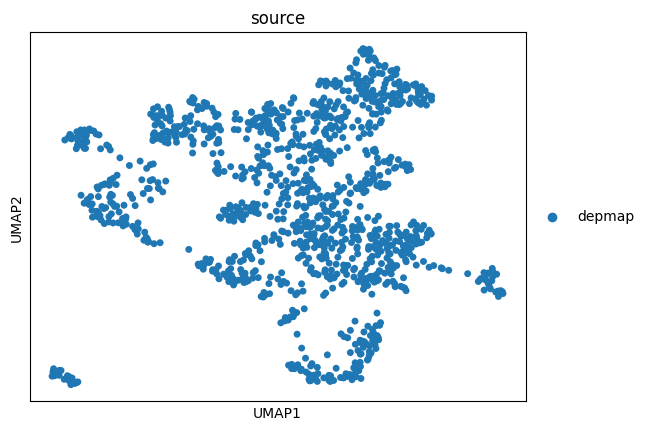

In [10]:

sc.pp.neighbors(adata,n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,color='source')

In [13]:
    # Tokenizing
print('T Tokenizing AnnData...')
tk = Tokenizer()
tokenized_dataset = tk.prepare_dataset(adata)
fname = "depmap.h5ad"
tk.save_pretraining_dataset(tokenized_dataset, fname.split('.')[0])


T Tokenizing AnnData...
> Tokenizer: 13932 genes successfully loaded.
> Processing dataset [===================.] (1207/1208) < 746 cells/s>
> Terminated. Elapsed: 1.6160991191864014s
> Tokenizer: 13932 genes successfully written.


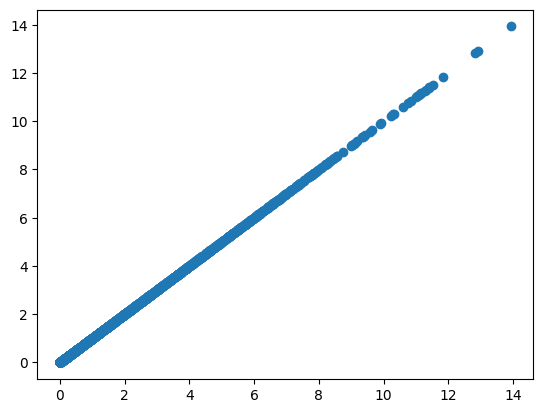

In [28]:
x = tokenized_dataset[0][2000:]
plt.scatter(x,adata[0,:].X)

In [43]:
print('T Loading and binning file...')
tk = Tokenizer(nbins=10)
tokenized_dataset = tk.load_pretraining_dataset('depmap')
print(len(tokenized_dataset))
print(tokenized_dataset[:5])


T Loading and binning file...
> Tokenizer: 13932 genes successfully loaded.
1208
[tensor([[4.0000e+00, 6.0000e+00, 2.4000e+01,  ..., 1.3887e+04, 1.3892e+04,
         1.3894e+04],
        [1.5841e+00, 6.6719e+00, 4.1261e-01,  ..., 3.1156e+00, 3.9241e+00,
         1.4762e+00],
        [6.0000e+00, 1.0000e+01, 3.0000e+00,  ..., 8.0000e+00, 8.0000e+00,
         6.0000e+00]]), tensor([[4.0000e+00, 6.0000e+00, 2.4000e+01,  ..., 1.3887e+04, 1.3892e+04,
         1.3894e+04],
        [7.8141e-01, 4.2740e+00, 2.2367e-01,  ..., 1.9053e+00, 6.1016e+00,
         1.0131e+00],
        [4.0000e+00, 9.0000e+00, 2.0000e+00,  ..., 7.0000e+00, 1.0000e+01,
         5.0000e+00]]), tensor([[4.0000e+00, 6.0000e+00, 2.4000e+01,  ..., 1.3887e+04, 1.3892e+04,
         1.3894e+04],
        [1.9508e+00, 3.9814e+00, 4.2385e-01,  ..., 3.3843e+00, 4.0108e+00,
         7.7330e+00],
        [6.0000e+00, 8.0000e+00, 3.0000e+00,  ..., 8.0000e+00, 8.0000e+00,
         1.0000e+01]]), tensor([[4.0000e+00, 6.0000e+00, 2.4000

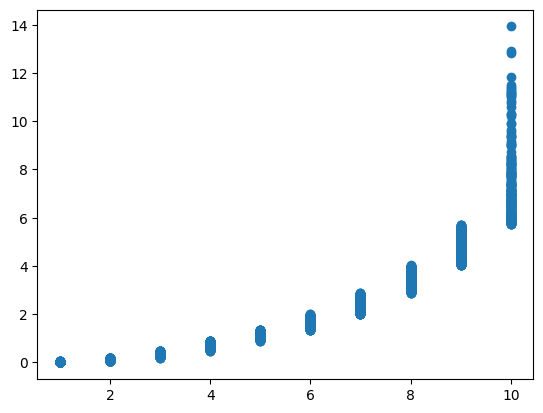

(array([200.,   0., 200.,   0., 200.,   0., 200.,   0., 200.,   0.,   0.,
        200.,   0., 200.,   0., 200.,   0., 200.,   0., 200.]),
 array([ 1.        ,  1.45000005,  1.89999998,  2.3499999 ,  2.79999995,
         3.25      ,  3.70000005,  4.1500001 ,  4.5999999 ,  5.05000019,
         5.5       ,  5.94999981,  6.4000001 ,  6.8499999 ,  7.30000019,
         7.75      ,  8.19999981,  8.64999962,  9.10000038,  9.55000019,
        10.        ]),
 <BarContainer object of 20 artists>)

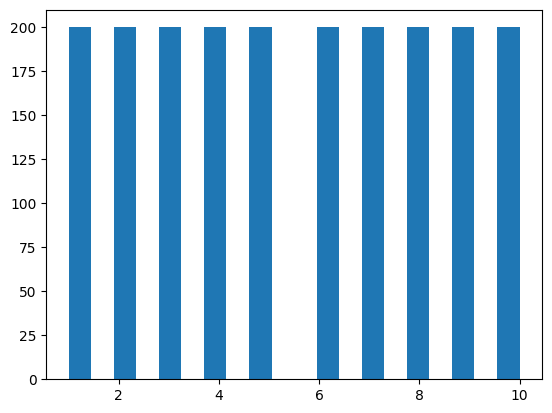

In [44]:
x = tokenized_dataset[0][2,:]
plt.scatter(x,adata[0,:].X)
plt.show()
plt.hist(x,bins=20)

In [45]:
from mscgpt.data_handler import DataHandler
from mscgpt.tokenizer import Tokenizer

print('T Creating Tokenizer')
tk = Tokenizer()
data = tk.load_pretraining_dataset('depmap')
print('T Loading dataset in data handler')
dh = DataHandler(32, 500, tk.pad_token, val_ratio=0.15, test_ratio=0.05)
dh.load_dataset(data)
print(dh)


T Creating Tokenizer
> Tokenizer: 13932 genes successfully loaded.
T Loading dataset in data handler
> Data Handler: Dataset successfully loaded.
[train,gid]	torch.Size([967, 2000])	tensor([ 4.,  6., 24., 25., 30., 32., 33., 34., 39., 42.])
[train,bin]	torch.Size([967, 2000])	tensor([3., 5., 2., 2., 1., 5., 4., 3., 2., 3.])
[train,cnt]	torch.Size([967, 2000])	tensor([1.5841, 6.6719, 0.4126, 0.2509, 0.0703, 5.2918, 2.9850, 1.9932, 0.2825,
        1.8831])
[val,gid]	torch.Size([181, 2000])	tensor([ 4.,  6., 24., 25., 30., 32., 33., 34., 39., 42.])
[val,bin]	torch.Size([181, 2000])	tensor([5., 5., 4., 2., 3., 3., 4., 5., 5., 5.])
[val,cnt]	torch.Size([181, 2000])	tensor([5.4143, 7.5126, 2.1116, 0.3515, 1.2523, 1.7318, 3.6675, 6.4635, 5.2843,
        7.1359])
[test,gid]	torch.Size([60, 2000])	tensor([ 4.,  6., 24., 25., 30., 32., 33., 34., 39., 42.])
[test,bin]	torch.Size([60, 2000])	tensor([3., 4., 3., 2., 2., 4., 3., 1., 5., 3.])
[test,cnt]	torch.Size([60, 2000])	tensor([1.6544, 4.3665, 

In [47]:
print('T Creating Tokenizer')
tk = Tokenizer()
data = tk.load_pretraining_dataset('depmap')
print('T Loading dataset in data handler')
dh = DataHandler(32, 500, tk.pad_token, val_ratio=0.15, test_ratio=0.05)
dh.load_dataset(data)
print('T Geting batch')
gids, bins = dh.get_batch('train')
print(gids.shape, bins.shape)
print(gids[0])
print(bins[0])


T Creating Tokenizer
> Tokenizer: 13932 genes successfully loaded.
T Loading dataset in data handler
> Data Handler: Dataset successfully loaded.
T Geting batch
torch.Size([32, 500]) torch.Size([32, 500])
tensor([ 6422, 13793,  4444, 11702, 10797,  4452,  8551,  4507, 10170, 11802,
        10289,   927,  9693,  2314,  7025,  5490,  1882,  5840, 10618,  2617,
         3791,  5477,  7608,   924,  1169, 12942,  8174,  9586, 10887,  4340,
         3322,  4683, 12075,  2748,  7574,  6183, 13315,  8689,  1498,  2482,
         9651,  2516,  5217, 12941,   416,  3746, 11928,  4572,  4767,  2703,
        10942,  5437,     6,   175,  5562,   145,  8078,  2755, 11726,  6527,
        13589,  9869,    60,  9280, 12223,  1396,  5495, 13892,  4909,  4372,
         3133,  9688,  8546,  3792,  1837,  2598,  2772,  9908, 11714,  3388,
        11150,  1065,  2297, 13862,  5587,  3089,  4894,  1651, 12579,  9685,
         8887,  7802,  5656,   204,  8500,  3812,  7817,  5798,  9320,  2002,
        11407, 

In [48]:
from mscgpt.tokenizer import Tokenizer
from mscgpt.data_handler import DataHandler
from mscgpt.gpt import MicroSCGPT, GeneExpressionRegressor


In [51]:
print('T Creating Tokenizer')
tk = Tokenizer()
data = tk.load_pretraining_dataset('depmap')
print('T Loading dataset in data handler')
dh = DataHandler(32, 500, tk.pad_token, val_ratio=0.15, test_ratio=0.05)
dh.load_dataset(data)
print('T Geting batch')
gids, bins = dh.get_batch('train')
print('T Forward pass')
model = MicroSCGPT(dh.ctx_size, tk.bins_size, tk.vocab_size)
output = model(gids, bins)
print(output.shape)


T Creating Tokenizer
> Tokenizer: 13932 genes successfully loaded.
T Loading dataset in data handler
> Data Handler: Dataset successfully loaded.
T Geting batch
T Forward pass
> MicroSCGPT: Model initialized with 2282496 parameters.
torch.Size([32, 500, 128])


In [52]:
print('T Creating Tokenizer')
tk = Tokenizer()
data = tk.load_pretraining_dataset('depmap')
print('T Loading dataset in data handler')
dh = DataHandler(8, tk.n_genes, tk.pad_token, val_ratio=0.15, test_ratio=0.05)
dh.load_dataset(data)
print('T Geting batch')
gids, bins, cnts = dh.get_batch('train')
print('T Forward pass')
model = MicroSCGPT(dh.ctx_size, tk.bins_size, tk.vocab_size)
output = model(gids, bins)
print('T Prediction')
model_gexpr = GeneExpressionRegressor(dh.ctx_size, model.embed_size, tk.n_genes)
genes_pred = model_gexpr(output)
print(genes_pred.shape)
print(genes_pred[0])


T Creating Tokenizer
> Tokenizer: 13932 genes successfully loaded.


FileNotFoundError: [Errno 2] No such file or directory: '/home/zinovyev/gits/micro-scgpt/data/pretrain/tabmuris_A.tk'